In [34]:
import re
import ast
import json
from graphviz import Digraph
import pandas as pd

# color the graph
import graph_tool.all as gt
import copy
import matplotlib.colors as mcolors
import sys

import seaborn as sns

def color_assignment(benchmark, task_style):
    cfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.colors'
    with open(cfile, 'r') as cfd:
        raw = cfd.read().split('\n')
        for ln in raw:
            if not ln: 
                continue
            task_name, actual = ln.split(',')
            if task_name not in task_style:
                task_style[task_name] = {}
            task_style[task_name]['actual'] = actual    

    #cfile = f'/local0/serverless-sim/results/{benchmark}.simcolors'
    #with open(cfile, 'r') as cfd:
    #    raw = cfd.read().split('\n')
    #    for ln in raw:
    #        if not ln: 
    #            continue
    #        task_name, simulator = ln.split(',')
    #        if task_name not in task_style:
    #            task_style[task_name] = {}
    #        task_style[task_name]['simulator'] = simulator 
        
    
    
def build_graph(benchmark, task_style):
    css_colors = list(mcolors.CSS4_COLORS.keys())
    gfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.g'

    with open(gfile, 'r') as fd:
        raw = fd.read().split('\n')
        g = gt.Graph(directed=True)
        vid_to_vx = {}
        name_to_vid = {}

        g.vertex_properties['name'] = g.new_vertex_property("string")
        g.vertex_properties['color'] = g.new_vertex_property("string")
        g.vertex_properties['worker'] = g.new_vertex_property("string")
        g.vertex_properties['icolor'] = g.new_vertex_property("int")
        g.vertex_properties['simcolor'] = g.new_vertex_property("string")
        g.vertex_properties['isimcolor'] = g.new_vertex_property("string")
        for ln in raw:
            if ln.startswith('v'):
                _, vid, name = ln.split(',', 2)
                v = g.add_vertex()
                vid_to_vx[vid] = v
                name_to_vid[name] = vid

                g.vp.name[v] = name
                try:
                    g.vp.icolor[v] = int(task_style[name]['actual'])
                    if g.vp.icolor[v] >= len(css_colors):
                        g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[0]]
                    else:
                        g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['actual'])]]

                    #g.vp.simcolor[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['simulator'])]]
                    #g.vp.isimcolor[v] = int(task_style[name]['simulator'])
                #print(name, g.vp.icolor[v])
                except KeyError:
                    print(f'Keyerror for {name}')
                    g.vp.color[v] = 'yellow'
                    g.vp.icolor[v] = 2

        for ln in raw:        
            if ln.startswith('e'):
                _, vsrc, vdst, _ = ln.split(',', 3)
                g.add_edge(vid_to_vx[vsrc], vid_to_vx[vdst])
    return g
            
colors = {'w0': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[0]],
    '10.255.23.108': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[0]],
    '10.255.23.109': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[1]],
    '10.255.23.110': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[2]],
    '10.255.23.115': mcolors.CSS4_COLORS[list(mcolors.CSS4_COLORS.keys())[3]]}
def update_runtime_state(benchmark, g, task_style):
    tasks = []
    jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'
    with open(jfile, 'r') as fd:
        stats = ast.literal_eval(fd.read())

        #print(json.dumps(stats, indent=4))
        
        min_ts = sys.maxsize
        for s in stats:
            task_style[s]['output_size'] = stats[s]['msg']['nbytes']
            task_style[s]['input_size'] = 0
            task_style[s]['remote_read'] = 0
            task_style[s]['local_read'] = 0
            task_style[s]['worker'] = stats[s]['worker'].split(':')[1].replace('/', '')
            startsstops = stats[s]['msg']['startstops']
            print(s, stats[s]['msg']['nbytes'])
            for ss in startsstops:
                if ss['action'] == 'inputsize': continue
                if ss['action'] == 'compute':
                    task_style[s]['compute_end'] = ss['stop']
                    task_style[s]['compute_start'] = ss['start']
                    task_style[s]['runtime'] = ss['stop'] - ss['start']
                if ss['start'] < min_ts:  min_ts = ss['start']
                if ss['stop'] < min_ts:  min_ts = ss['stop']
            #break


        for s in stats:
            startsstops = stats[s]['msg']['startstops']
            min_start = sys.maxsize
            max_end = 0

            for ss in startsstops:
                if ss['action'] == 'inputsize': continue
                if ss['start'] < min_start:  min_start = ss['start']
                if ss['stop'] > max_end:  max_end = ss['stop']

            tasks.append({'name': s, 'start_ts': min_start - min_ts, 'end_ts': max_end - min_ts, 
                          'worker': stats[s]['worker'].split(':')[1].replace('/', '')})
    
    
        #total amount of data accessed, data accessed remotely, data accessed locally
        for v in g.vertices():
            for vi in v.in_neighbors():
                task_style[g.vp.name[v]]['input_size'] += task_style[g.vp.name[vi]]['output_size']
                if task_style[g.vp.name[v]]['worker'] == task_style[g.vp.name[vi]]['worker']:
                    task_style[g.vp.name[v]]['local_read'] += task_style[g.vp.name[vi]]['output_size']
                else:
                    task_style[g.vp.name[v]]['remote_read'] += task_style[g.vp.name[vi]]['output_size']
                  
        for v in g.vertices():
            g.vp.worker[v] = task_style[g.vp.name[v]]['worker']
            g.vp.color[v] = colors[task_style[g.vp.name[v]]['worker']]
            
        #Check the slack for the prefetching
        bw = 10*(1<<27) # 10 Gbps (1<<30)/(1<<3)
        not_from_remote = 0
        for v in g.vertices():
            parents_end = []
            for vi in v.in_neighbors():
                parents_end.append(task_style[g.vp.name[vi]]['compute_end'])
                
            if len(parents_end):
                max_end = max(parents_end)
                
                for vi in v.in_neighbors():
                    if max_end == task_style[g.vp.name[vi]]['compute_end'] and task_style[g.vp.name[vi]]['worker'] != task_style[g.vp.name[v]]['worker']:
                        print(f'Slack come from local chain')
                        not_from_remote += 1
            

                print(f'slack for {g.vp.name[v]}: {round(1000*(max(parents_end) - min(parents_end)), 2)}msec',
                     '\t runtime:', round(1000*task_style[g.vp.name[vi]]['runtime'], 4), 'msec',
                     '\t remote read', task_style[g.vp.name[v]]['remote_read']/bw)
        print(not_from_remote)


worker_color = {'10.255.23.108': '#e41a1c',
    '10.255.23.109': '#984ea3',
    '10.255.23.110': '#ff7f00',
    '10.255.23.115': '#4daf4a'}

def plot_graph(g):        
    dg = Digraph('G', filename=f'{benchmark}.chaincolor.gv', format='png')
    for v in g.vertices():
        dg.attr('node', shape='ellipse', style='filled', color=g.vp.color[v])
        dg.attr('node', shape='ellipse', style="filled,solid",
                penwidth="3",
                fillcolor=g.vp.color[v],
                color=worker_color[g.vp.worker[v]])
        
        dg.node(f'{v}, color({g.vp.icolor[v]})')

    for e in g.edges():
        dg.edge(f'{e.source()}, color({g.vp.icolor[e.source()]})', 
                f'{e.target()}, color({g.vp.icolor[e.target()]})')



    dg.view(f'/local0/serverless/evaluation/plots/{benchmark}.chaincolor', quiet=False)

    '''
    dg = Digraph('G', filename=f'{benchmark}.simulator.gv', format='png')
    for v in g.vertices():
        dg.attr('node', shape='ellipse', style='filled', color=g.vp.simcolor[v])
        dg.node(f'{v}, color({g.vp.isimcolor[v]})')

    for e in g.edges():
        dg.edge(f'{e.source()}, color({g.vp.isimcolor[e.source()]})', 
                f'{e.target()}, color({g.vp.isimcolor[e.target()]})')


    dg.view(f'{benchmark}.simulator', quiet=False)
    '''


    

benchmark = 'dom6x4x1G1B_d25acbb4'
#benchmark = 'd10b692c_ba7a'
task_style = {}
color_assignment(benchmark, task_style)
g = build_graph(benchmark, task_style)
update_runtime_state(benchmark, g, task_style)
plot_graph(g)

#task_style


execute_point_no_scratch-149b2ab4-6472-4638-a06a-1ad8f23364c0 1073741824
execute_point_no_scratch-a41fe233-0e64-4741-8e42-3d856cdc7a64 1073741824
execute_point_no_scratch-62e57599-b945-4684-9f9c-c12063522392 1073741824
execute_point_no_scratch-8c253cd2-801b-4519-839b-5596c369b849 1073741824
execute_point_no_scratch-232eb981-71a6-4b78-b12a-c6d628941598 1073741824
execute_point_no_scratch-87c45a80-89c9-440b-9611-f7e54aeb06b4 1073741824
execute_point_no_scratch-74b182b5-d641-49e1-84b2-323a342300fd 1073741824
execute_point_no_scratch-3cd0ab9f-5828-4612-8ce4-751bc4986698 1073741824
execute_point_no_scratch-db6a6352-cb05-47eb-a557-eae6d456d0f4 1073741824
execute_point_no_scratch-8ca59e4b-c3fb-40e3-97ac-e33255f6ae18 1073741824
execute_point_no_scratch-270c1e24-1946-4ae5-a4c0-b7fec6c03cdd 1073741824
execute_point_no_scratch-98b4bdf8-e66a-465f-a71d-50e0d5a8a061 1073741824
execute_point_no_scratch-816310f7-3100-4ab2-8be7-39b21b9a1a31 1073741824
execute_point_no_scratch-4f57e892-49d9-4e0d-8c70-c8

In [26]:
# T1, Tfin

# The slack in the end time of the parents of a node

# distribution of runtime of tasks with the same operation
df = pd.DataFrame(data= task_style.values())

df


,actual,output_size,input_size,remote_read,local_read,worker,compute_end,compute_start,runtime
0,1,1073741824,0,0,0,10.255.23.115,1.621970e+09,1.621970e+09,5.762248
1,1,16,6442450944,5368709120,1073741824,10.255.23.115,1.621970e+09,1.621970e+09,0.002792
2,2,1073741824,1073741824,1073741824,0,10.255.23.109,1.621970e+09,1.621970e+09,5.570660
3,2,1073741824,2147483648,0,2147483648,10.255.23.109,1.621970e+09,1.621970e+09,5.863606
4,2,1073741824,2147483648,0,2147483648,10.255.23.109,1.621970e+09,1.621970e+09,5.759059
5,3,1073741824,0,0,0,10.255.23.109,1.621970e+09,1.621970e+09,5.529388
6,3,1073741824,1073741824,0,1073741824,10.255.23.109,1.621970e+09,1.621970e+09,5.741220


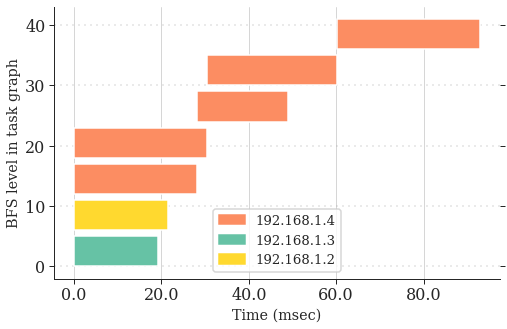

In [63]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import os
import json
import itertools
import matplotlib
import matplotlib.ticker as ticker

def format_xticks(x, pos=None):
    return x
    #return str(int(x*1000))
    
    
gfile = f'/local0/serverless-sim/results/{benchmark}.syncwdeser.chain_color.log'


with open(gfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    for ts in data['tasks']:
        print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
    

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')


# Setting graph attribute
ax.grid(True)

workers_color = {'192.168.1.44': '#fc8d62',
               '192.168.1.165': '#66c2a5', 
                '192.168.1.10': '#ffd92f' }
workers_load={}
with open(gfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    base = 0
    size = 5
    margin = 1
    for ts in data['tasks']:
        #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
        if ts['worker'] not in workers_load:
            workers_load[ts['worker']] = []
        #workers_load[ts['worker']].append((ts['start_ts'], ts['end_ts'] - ts['start_ts']))
        ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
                       facecolors =(workers_color[ts['worker']]))
        base += (size + margin)
ax.legend(['192.168.1.4', '192.168.1.3', '192.168.1.2'], loc=8)
ax.get_legend().legendHandles[0].set_color('#fc8d62')
ax.get_legend().legendHandles[1].set_color('#66c2a5')
ax.get_legend().legendHandles[2].set_color('#ffd92f')

1023


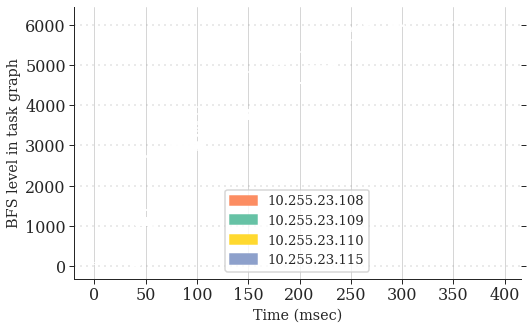

In [511]:
    
def format_xticks(x, pos=None):
    return str(int(x*1000))

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')


# Setting graph attribute
ax.grid(True)

workers_color = {'10.255.23.108': '#fc8d62',
                 '10.255.23.109': '#66c2a5', 
                 '10.255.23.110': '#ffd92f',
                 '10.255.23.115': '#8da0cb'}



base = 0
size = 5
margin = 1
for ts in tasks:
    #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
    if ts['worker'] not in workers_load:
        workers_load[ts['worker']] = []
    ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
                   facecolors =(workers_color[ts['worker']]))
    base += (size + margin)
    
ax.legend(list(workers_color.keys()), loc=8)
ax.get_legend().legendHandles[0].set_color('#fc8d62')
ax.get_legend().legendHandles[1].set_color('#66c2a5')
ax.get_legend().legendHandles[2].set_color('#ffd92f')
ax.get_legend().legendHandles[3].set_color('#8da0cb')

In [542]:
jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'


tasks = []
with open(jfile, 'r') as fd:
    stats = ast.literal_eval(fd.read())
    task_time = []
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        for ss in startsstops:
            if ss['action'] == 'compute': 
                #print(s, ss['stop'] - ss['start'], task_style[s]['output_size'])
                task_time.append(ss['stop'] - ss['start'])
import numpy as np
arr = np.array(task_time)

# measures of central tendency
mean = np.mean(arr)
median = np.median(arr)
  
# measures of dispersion
_min = np.amin(arr)
_max = np.amax(arr)
range = np.ptp(arr)
varience = np.var(arr)
sd = np.std(arr)
  
print("Descriptive analysis")
print("Array =", arr)
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", _min)
print("Maximum =", _max)
print("Range =", range)
print("Varience =", varience)
print("Standard Deviation =", sd)

Descriptive analysis
Array = [6.93798065e-05 2.28881836e-05 3.99398804e-03 ... 4.76837158e-05
 3.91006470e-05 4.48226929e-05]
Measures of Central Tendency
Mean = 0.002175582585563175
Median = 8.344650268554688e-06
Measures of Dispersion
Minimum = 3.0994415283203125e-06
Maximum = 0.053134918212890625
Range = 0.053131818771362305
Varience = 3.946271315805763e-05
Standard Deviation = 0.0062819354627421655


In [480]:
jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'


tasks = []
workers = {}
with open(jfile, 'r') as fd:
    stats = ast.literal_eval(fd.read())
    
    min_ts = sys.maxsize
    print(len(stats))
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        print(s, stats[s]['worker'])
        for ss in startsstops:
            if ss['action'] == 'inputsize': continue
            if ss['start'] < min_ts:  min_ts = ss['start']
            if ss['stop'] < min_ts:  min_ts = ss['stop']
        
        ws = stats[s]['worker']
        if ws not in workers:
            workers[ws] = 0
        workers[ws] += 1    
        #break
            
            
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        min_start = sys.maxsize
        max_end = 0
        
        for ss in startsstops:
            if ss['action'] == 'inputsize': continue
            if ss['start'] < min_start:  min_start = ss['start']
            if ss['stop'] > max_end:  max_end = ss['stop']
        
        tasks.append({'name': s, 'start_ts': min_start - min_ts, 'end_ts': max_end - min_ts, 
                      'worker': stats[s]['worker'].split(':')[1].replace('/', ''),
                     'short_name': s.split('-')[0].replace("('", )})
        #break
    

768
('random_sample-3589e62988427c0de37f225ba9ed313c', 0, 14) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 11) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 8, 1) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 8, 0) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 1) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 13, 13) tcp://10.255.23.109:34511
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 4, 11) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 0) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 10, 10) tcp://10.255.23.110:43021
('random_sample-3589e62988427c0de37f225ba9ed313c', 0, 8) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 10, 0) tcp://10.255.23.110:43021
('random_sample-cf385d1dbd8c3ef3bc1924c155f7486f', 14, 12) tcp://10.255.

In [512]:
df = pd.DataFrame(tasks)
df['runtime'] = df['end_ts'] - df['start_ts']
df

,name,start_ts,end_ts,worker,runtime
0,add-934864d6-8a87-49b5-a815-cec7a2ed843c,0.037606,0.037675,10.255.23.115,0.000069
1,add-d5b2db9e-8cce-4c90-8cb9-2968749f3eff,0.037783,0.037806,10.255.23.115,0.000023
2,add-deb5f76e-6077-4824-826c-efb36ec2cb8f,0.037874,0.041868,10.255.23.115,0.003994
3,add-2beb9684-9a07-4afd-8133-2158d85d84fa,0.037920,0.044914,10.255.23.115,0.006994
4,add-edd09d53-329f-4685-8e0e-52e40bdc20bb,0.038078,0.045166,10.255.23.115,0.007089
...,...,...,...,...,...
1018,add-33ec713e-483f-4375-aba3-4a6e02c56da7,0.345843,0.345854,10.255.23.110,0.000010
1019,add-99545666-fbac-4b2a-9873-84ee97ede34c,0.338607,0.343286,10.255.23.108,0.004679
1020,add-9f5f3fc3-5fa4-4d82-9b48-1824cd758b66,0.376662,0.380290,10.255.23.115,0.003628
1021,add-107ef289-6c26-45d0-b05f-588d7b236d14,0.386185,0.388679,10.255.23.115,0.002493


w1 w1
w1 w2
w1 w3
w1 w4
w2 w1
w2 w2
w2 w3
w2 w4
w3 w1
w3 w2
w3 w3
w3 w4
w4 w1
w4 w2
w4 w3
w4 w4


In [65]:
import random

data = {'D0':{'msg':{'startstops':[{'action':'compute','start':0,'stop':10}]}},'D1':{'msg':{'startstops':[{'action':'compute','start':0,'stop':16}]}}, 'D2':{'msg':{'startstops':[{'action':'compute','start':0,'stop':8}]}},'D3':{'msg':{'startstops':[{'action':'compute','start':0,'stop':12}]}},'D4':{'msg':{'startstops':[{'action':'compute','start':0,'stop':14}]}},'D5':{'msg':{'startstops':[{'action':'compute','start':0,'stop':10}]}},'D6':{'msg':{'startstops':[{'action':'compute','start':0,'stop':2}]}}}

for x in data:
    data[x]['msg']['nbytes'] = random.randint(128, 512)*(1<<20)
    data[x]['worker'] = 'https://w0:9000'

with open('/local0/serverless-sim/stats/tree_reduction_dag.json', 'w') as fd:
    json.dump(data, fd)

In [31]:
from operator import itemgetter

sched = [('j2', 0.0, '10.255.23.110', 5.7622480392456055, 'execute_point_no_scratch-03186637-b0d8-4595-95b3-9e6d25e47b6a'), ('j1', 0.23285961, '10.255.23.109', 5.762248037734375, 'execute_point_no_scratch-ee035c5c-579f-4304-ab6f-65b4d1e01f18'), ('j5', 5.762248, '10.255.23.110', 11.33290811428833, 'execute_point_no_scratch-bc91cf33-92c4-4a21-8cc5-841c5b9ac7ee'), ('j0', 10.655294, '10.255.23.115', 16.396514235824583, 'execute_point_no_scratch-78acb0c0-b13b-458d-abca-51bb1ed10997'), ('j6', 11.332908, '10.255.23.110', 17.196514214523315, 'execute_point_no_scratch-ebd9f1da-30bb-4051-82dd-9ecad346c639'), ('j3', 17.196514, '10.255.23.110', 22.955572952331543, 'execute_point_no_scratch-52eee92b-8989-4dfb-94c5-4c0e64205480'), ('j4', 22.955573, '10.255.23.110', 22.9583646431427, 'join-4efce6b7-8f6e-4f28-a3ad-d582edad9419')]

res = max(sched, key=itemgetter(3))
res

optimal_stat = {}
for s in sched:
    optimal_stat[s[4]] = {'worker': s[2], 'start': s[1], 'end': s[3]}
    
optimal_stat, res

({'execute_point_no_scratch-03186637-b0d8-4595-95b3-9e6d25e47b6a': {'worker': '10.255.23.110',
   'start': 0.0,
   'end': 5.7622480392456055},
  'execute_point_no_scratch-ee035c5c-579f-4304-ab6f-65b4d1e01f18': {'worker': '10.255.23.109',
   'start': 0.23285961,
   'end': 5.762248037734375},
  'execute_point_no_scratch-bc91cf33-92c4-4a21-8cc5-841c5b9ac7ee': {'worker': '10.255.23.110',
   'start': 5.762248,
   'end': 11.33290811428833},
  'execute_point_no_scratch-78acb0c0-b13b-458d-abca-51bb1ed10997': {'worker': '10.255.23.115',
   'start': 10.655294,
   'end': 16.396514235824583},
  'execute_point_no_scratch-ebd9f1da-30bb-4051-82dd-9ecad346c639': {'worker': '10.255.23.110',
   'start': 11.332908,
   'end': 17.196514214523315},
  'execute_point_no_scratch-52eee92b-8989-4dfb-94c5-4c0e64205480': {'worker': '10.255.23.110',
   'start': 17.196514,
   'end': 22.955572952331543},
  'join-4efce6b7-8f6e-4f28-a3ad-d582edad9419': {'worker': '10.255.23.110',
   'start': 22.955573,
   'end': 22.958

In [30]:
def plot_optimal(g):
    
    
    dg = Digraph('G', filename=f'{benchmark}.optimal.gv', format='png')
    for v in g.vertices():
        print(v, optimal_stat[g.vp.name[v]])
        dg.attr('node', shape='ellipse', style='filled', color=colors[optimal_stat[g.vp.name[v]]['worker']])
        dg.node(f'{v}, color({g.vp.icolor[v]})')

    for e in g.edges():
        dg.edge(f'{e.source()}, color({g.vp.icolor[e.source()]})', 
                f'{e.target()}, color({g.vp.icolor[e.target()]})')



    dg.view(f'./plots/{benchmark}', quiet=False)

    '''
    dg = Digraph('G', filename=f'{benchmark}.simulator.gv', format='png')
    for v in g.vertices():
        dg.attr('node', shape='ellipse', style='filled', color=g.vp.simcolor[v])
        dg.node(f'{v}, color({g.vp.isimcolor[v]})')

    for e in g.edges():
        dg.edge(f'{e.source()}, color({g.vp.isimcolor[e.source()]})', 
                f'{e.target()}, color({g.vp.isimcolor[e.target()]})')


    dg.view(f'{benchmark}.optimal.simulator', quiet=False)
    '''
plot_optimal(g)

0 {'worker': '10.255.23.115', 'start': 10.655294, 'end': 16.396514235824583}
1 {'worker': '10.255.23.109', 'start': 0.23285961, 'end': 5.762248037734375}
2 {'worker': '10.255.23.110', 'start': 0.0, 'end': 5.7622480392456055}
3 {'worker': '10.255.23.110', 'start': 17.196514, 'end': 22.955572952331543}
4 {'worker': '10.255.23.110', 'start': 22.955573, 'end': 22.9583646431427}
5 {'worker': '10.255.23.110', 'start': 5.762248, 'end': 11.33290811428833}
6 {'worker': '10.255.23.110', 'start': 11.332908, 'end': 17.196514214523315}


In [5]:
df

,actual,output_size,input_size,remote_read,local_read,worker,compute_end,compute_start,runtime
0,1,16,0,0,0,10.255.23.108,1.621625e+09,1.621625e+09,0.001366
1,1,16,96,32,64,10.255.23.109,1.621625e+09,1.621625e+09,0.000012
2,2,16,16,0,16,10.255.23.108,1.621625e+09,1.621625e+09,0.000398
3,2,16,32,16,16,10.255.23.109,1.621625e+09,1.621625e+09,0.000236
4,2,16,32,0,32,10.255.23.109,1.621625e+09,1.621625e+09,0.000221
5,3,16,0,0,0,10.255.23.109,1.621625e+09,1.621625e+09,0.001782
6,3,16,16,0,16,10.255.23.109,1.621625e+09,1.621625e+09,0.000119


<AxesSubplot:xlabel='Model', ylabel='runtime'>

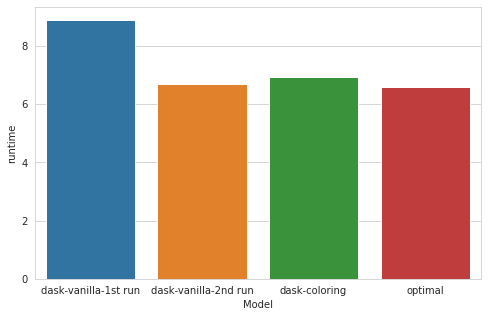

In [39]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import os
import json
import itertools
import matplotlib
import matplotlib.ticker as ticke

rdf = pd.DataFrame(data=[{'Model': 'dask-vanilla-1st run', 'runtime': 8.892150}, # does the first run or second run would change the optimal 
    {'Model': 'dask-vanilla-2nd run', 'runtime': 6.683537},
    {'Model': 'dask-coloring', 'runtime': 6.938181},
    {'Model': 'optimal', 'runtime': 6.572880313580322}])



fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='Model', y='runtime', data=rdf, ax=ax)

In [23]:
# random 
# optimal 
# coloring-CH
# coloring-RR
# vanilla-DASK
# the gap between optimal and random is very important
# where the huristitic for coloring landing 
# what happens when we use consistent hashing or what we have more colors that workers and there would be collisions again. 
# what would happen to we 100 nodes? 
# what does the solver do when we change the relative speed of compute and network. (play with the bandwidth)
# Do it for different graphs
# check gurobi solver. 
# in the simulator check the optimal solution with CPU sharing and how much it differ. (just use the schedule)
# get the minimum time for the execute time and check if they are varying alot. 


# send the 3 4 graphs that we think are interesting

# for coloring as many workers as you have colors. so we avoid collision. 

In [329]:
df = pd.read_csv('/local0/serverless/serverless-sim/results/statistics.csv')

df['index_key'] = df['appname'] + '_' + df['scheduler'] + 'p'
dp = df.pivot(index='appname',columns='scheduler', values='end2end')

conv = []
for column in dp:
    dp[f'{column}p'] = (dp[column]/dp['optimal'] - 1)*100
    conv.append(f'{column}p')

dp = dp.reset_index()
    
dm = pd.melt(dp, id_vars='appname', value_vars=conv, value_name='runtime_percent')
dm['index_key'] = dm['appname'] + '_' + dm['scheduler']

df = pd.merge(df, dm, on="index_key").drop('index_key', axis=1)

df

,appname_x,scheduler_x,end2end,remote_read,local_read,transimit(s),compute(s),deseriation(s),serialization(s),task_time,appname_y,scheduler_y,runtime_percent
0,all2all4x41GB1B_58e5586a,optimal,26.200002,51539607552,17179869184,38.400020,90,0,0.0,100.400006,all2all4x41GB1B_58e5586a,optimalp,0.000000
1,all2all3x41GB1B_fec067dc,optimal,26.200002,28991029248,12884901888,21.600012,68,0,0.0,76.000004,all2all3x41GB1B_fec067dc,optimalp,0.000000
2,stencil_1d4x41GB1B_7013403d,optimal,26.200002,34359738368,15032385536,25.600014,86,0,0.0,96.400006,stencil_1d4x41GB1B_7013403d,optimalp,0.000000
3,stencil_1d5x41GB1B_a298f007,optimal,40.400002,41875931136,21474836480,31.200017,113,0,0.0,155.800008,stencil_1d5x41GB1B_a298f007,optimalp,0.000000
4,stencil_1d_periodic5x41GB1B_0f26fdac,optimal,42.200002,49392123904,20401094656,36.800020,109,0,0.0,157.800007,stencil_1d_periodic5x41GB1B_0f26fdac,optimalp,0.000000
5,tree5x41GB1B_e6a59da7,optimal,25.800000,12884901888,11811160064,9.600005,60,0,0.0,71.600000,tree5x41GB1B_e6a59da7,optimalp,0.000000
6,tree7x41GB1B_41b765fc,optimal,26.800000,17179869184,11811160064,12.800007,71,0,0.0,100.199999,tree7x41GB1B_41b765fc,optimalp,0.000000
7,randomnearest5x41GB1B_d41204ff,optimal,29.400001,27917287424,18253611008,20.800011,102,0,0.0,126.800004,randomnearest5x41GB1B_d41204ff,optimalp,0.000000
8,all2all4x41GB1B_58e5586a,vanilla,72.200002,32212254720,36507222016,24.000013,90,0,0.0,238.400006,all2all4x41GB1B_58e5586a,vanillap,175.572508
9,all2all3x41GB1B_fec067dc,vanilla,49.200002,21474836480,20401094656,16.000009,68,0,0.0,122.000004,all2all3x41GB1B_fec067dc,vanillap,87.786254


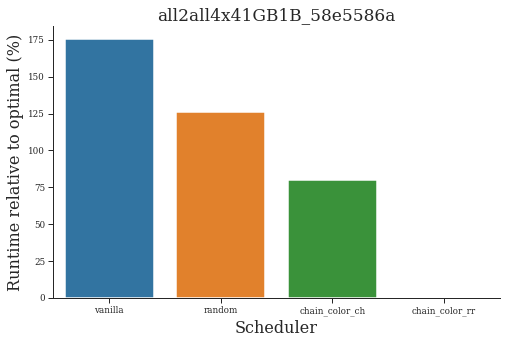

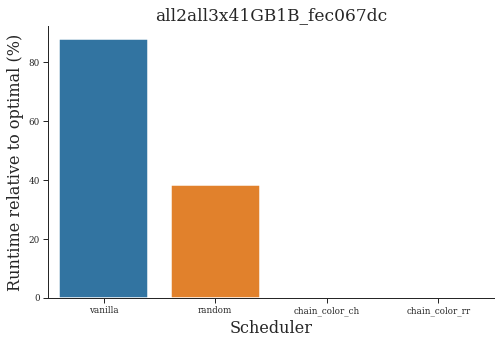

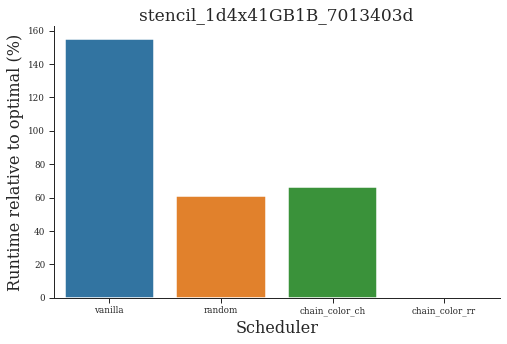

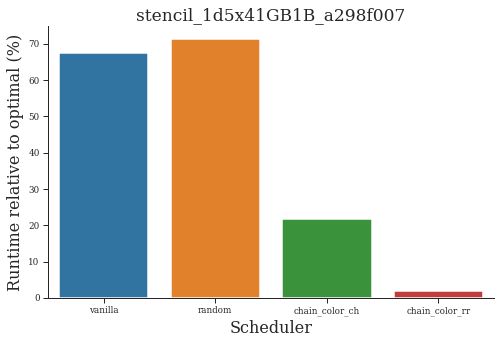

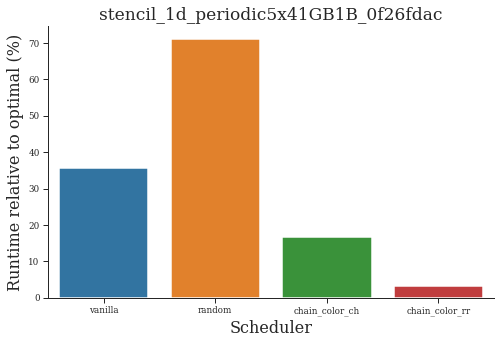

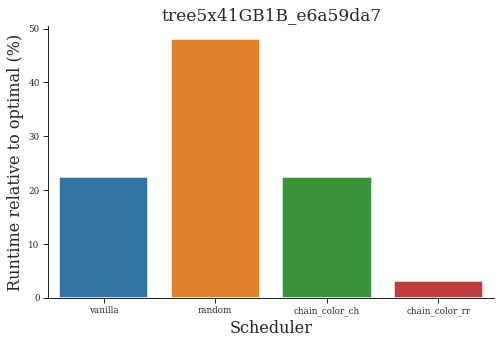

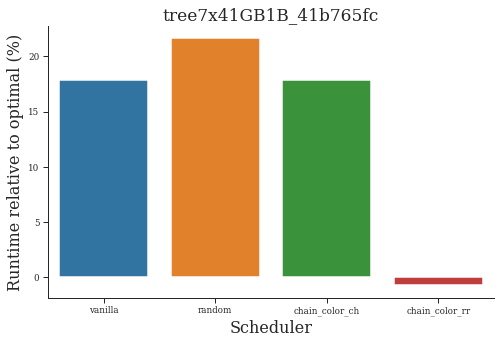

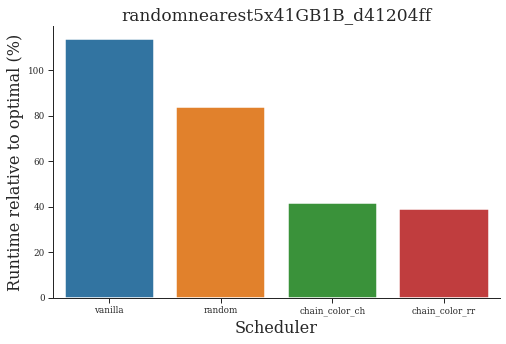

In [331]:
apps = df['appname_x'].unique()

for app in apps:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.barplot(x='scheduler_x',y='runtime_percent', 
                data=df[(df['appname_x'] == app) & (df['scheduler_x']!='optimal')])
    sns.despine()
    ax.set_xlabel('Scheduler', fontsize=16)
    ax.set_ylabel('Runtime relative to optimal (%)', fontsize=16)
    ax.set_title(app, fontsize=17)

In [301]:
df

,appname_x,scheduler_x,end2end,remote_read,local_read,transimit(s),compute(s),deseriation(s),serialization(s),task_time,appname_y,scheduler_y,runtime_percent
0,all2all4x41GB1B_58e5586a,optimal,39.800009,51539607552,17179869184,120.000064,90,0,0.0,128.400020,all2all4x41GB1B_58e5586a,optimalp,0.000000
1,all2all4x41GB1B_58e5586a,vanilla,81.000009,32212254720,36507222016,110.400059,90,0,0.0,244.800020,all2all4x41GB1B_58e5586a,vanillap,103.517565
2,all2all4x41GB1B_58e5586a,chain_color_ch,55.200006,40802189312,27917287424,84.800045,90,0,0.0,159.600012,all2all4x41GB1B_58e5586a,chain_color_chp,38.693450
3,all2all4x41GB1B_58e5586a,chain_color_rr,39.800009,51539607552,17179869184,120.000064,90,0,0.0,128.400020,all2all4x41GB1B_58e5586a,chain_color_rrp,0.000000


In [332]:
df = pd.read_csv('/local0/serverless/serverless-sim/results/statistics.csv')

df['index_key'] = df['appname'] + '_' + df['scheduler'] + 'p'
dp = df.pivot(index='appname',columns='scheduler', values='task_time')

conv = []
for column in dp:
    dp[f'{column}p'] = (dp[column]/dp['optimal'] - 1)*100
    conv.append(f'{column}p')

dp = dp.reset_index()
    
dm = pd.melt(dp, id_vars='appname', value_vars=conv, value_name='tasktime_percent')
dm['index_key'] = dm['appname'] + '_' + dm['scheduler']

df = pd.merge(df, dm, on="index_key").drop('index_key', axis=1)

df

,appname_x,scheduler_x,end2end,remote_read,local_read,transimit(s),compute(s),deseriation(s),serialization(s),task_time,appname_y,scheduler_y,tasktime_percent
0,all2all4x41GB1B_58e5586a,optimal,26.200002,51539607552,17179869184,38.400020,90,0,0.0,100.400006,all2all4x41GB1B_58e5586a,optimalp,0.000000e+00
1,all2all3x41GB1B_fec067dc,optimal,26.200002,28991029248,12884901888,21.600012,68,0,0.0,76.000004,all2all3x41GB1B_fec067dc,optimalp,0.000000e+00
2,stencil_1d4x41GB1B_7013403d,optimal,26.200002,34359738368,15032385536,25.600014,86,0,0.0,96.400006,stencil_1d4x41GB1B_7013403d,optimalp,0.000000e+00
3,stencil_1d5x41GB1B_a298f007,optimal,40.400002,41875931136,21474836480,31.200017,113,0,0.0,155.800008,stencil_1d5x41GB1B_a298f007,optimalp,0.000000e+00
4,stencil_1d_periodic5x41GB1B_0f26fdac,optimal,42.200002,49392123904,20401094656,36.800020,109,0,0.0,157.800007,stencil_1d_periodic5x41GB1B_0f26fdac,optimalp,0.000000e+00
5,tree5x41GB1B_e6a59da7,optimal,25.800000,12884901888,11811160064,9.600005,60,0,0.0,71.600000,tree5x41GB1B_e6a59da7,optimalp,0.000000e+00
6,tree7x41GB1B_41b765fc,optimal,26.800000,17179869184,11811160064,12.800007,71,0,0.0,100.199999,tree7x41GB1B_41b765fc,optimalp,0.000000e+00
7,randomnearest5x41GB1B_d41204ff,optimal,29.400001,27917287424,18253611008,20.800011,102,0,0.0,126.800004,randomnearest5x41GB1B_d41204ff,optimalp,0.000000e+00
8,all2all4x41GB1B_58e5586a,vanilla,72.200002,32212254720,36507222016,24.000013,90,0,0.0,238.400006,all2all4x41GB1B_58e5586a,vanillap,1.374502e+02
9,all2all3x41GB1B_fec067dc,vanilla,49.200002,21474836480,20401094656,16.000009,68,0,0.0,122.000004,all2all3x41GB1B_fec067dc,vanillap,6.052631e+01


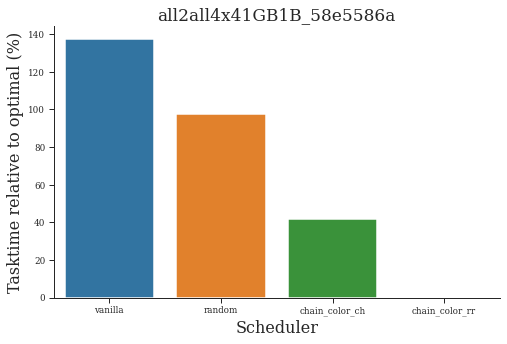

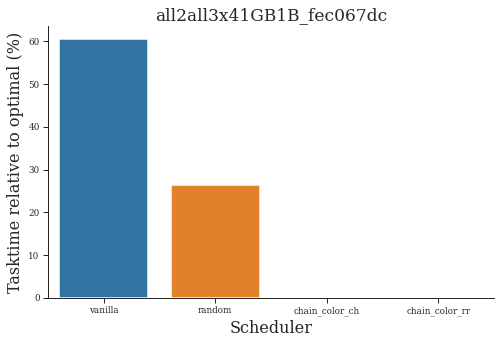

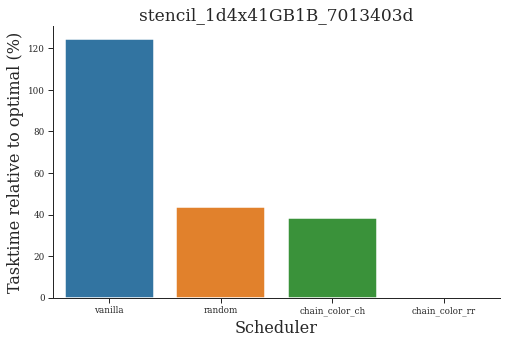

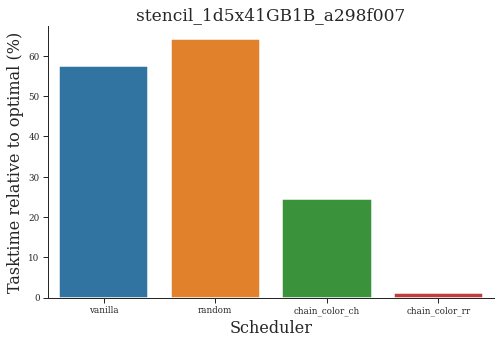

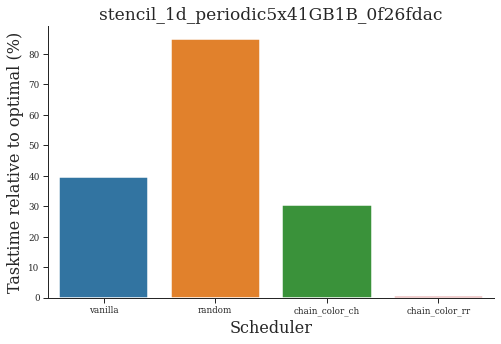

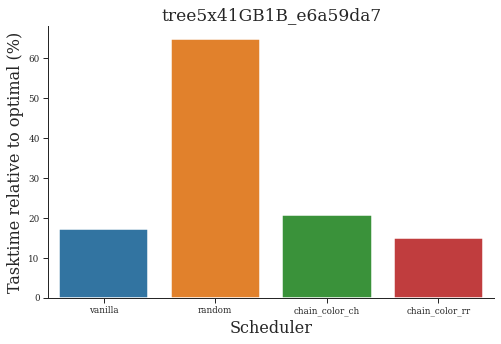

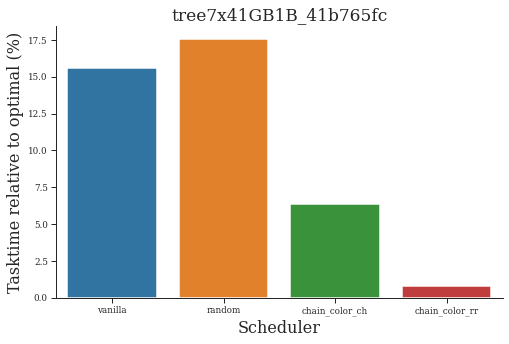

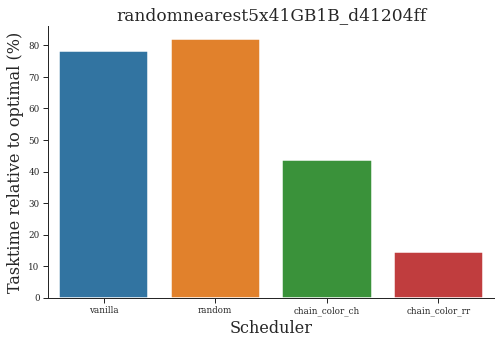

In [333]:
apps = df['appname_x'].unique()

for app in apps:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.barplot(x='scheduler_x',y='tasktime_percent', 
                data=df[(df['appname_x'] == app) & (df['scheduler_x']!='optimal')])
    sns.despine()
    ax.set_xlabel('Scheduler', fontsize=16)
    ax.set_ylabel('Tasktime relative to optimal (%)', fontsize=16)
    ax.set_title(app, fontsize=17)

<AxesSubplot:xlabel='scheduler_x'>

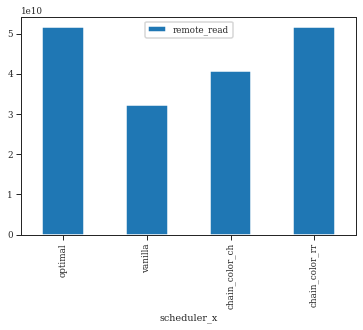

In [310]:
df.plot.bar(x='scheduler_x', y='remote_read')

In [ ]:
# what would the graph look like that is worse for optimal. 

# svm parallelization is an important 

# what would make our huristics bad compare to optimal. 

# consistent hashing and scalability. 

# what is the worst case we could have compare to optimal (competitive analysis).

# do we want to come up with the fractional solution and see how it works for the fractional and run it for some of those we have integer solution. 

<ipython-input-334-106b14340171>:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


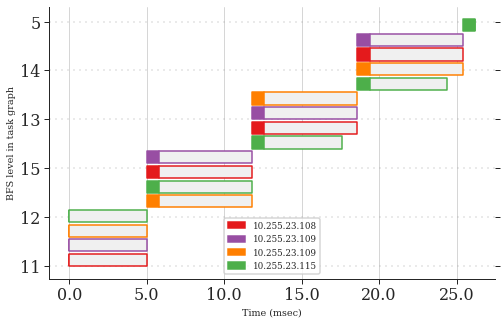

<ipython-input-334-106b14340171>:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


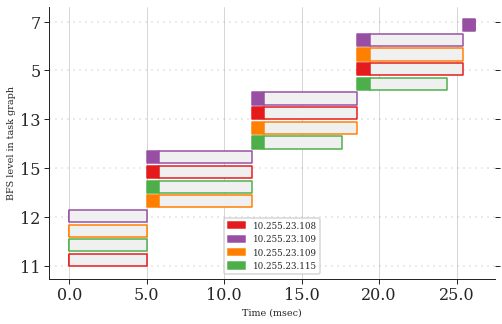

execute_point_no_scratch-44cf700e-2280-48a4-9d70-2185a28e1633 0 5 10.255.23.110
execute_point_no_scratch-c45200fd-6261-4345-bc4e-9bb98c513229 0 15.0 10.255.23.108
execute_point_no_scratch-80b27d8c-307c-48fc-8a65-e899e1b6682f 0 15.0 10.255.23.108
execute_point_no_scratch-39f5a039-ada4-45d3-ad70-2945a6e9f91d 0 15.0 10.255.23.108
execute_point_no_scratch-9a1fdfc4-9a42-4ff0-a48f-fd8f4317582c 15.0 21.80000042617321 10.255.23.110
execute_point_no_scratch-2fa5355a-f8fe-4d78-a3c6-d96fe811af46 15.0 33.80000042617321 10.255.23.108
execute_point_no_scratch-26026e7b-94a7-410c-b98d-7dfe2ca976df 15.0 33.80000042617321 10.255.23.108
execute_point_no_scratch-ec188590-d49d-43cd-944f-ce86f554771b 15.0 33.80000042617321 10.255.23.108
execute_point_no_scratch-45dcc8da-7d8f-4469-bf17-cb490c0292c3 33.80000042617321 39.600000852346426 10.255.23.110
execute_point_no_scratch-04993c02-9a45-48df-99e8-23afbdadc704 33.80000042617321 52.600000852346426 10.255.23.108
execute_point_no_scratch-bf58f208-a1ee-469a-910f-

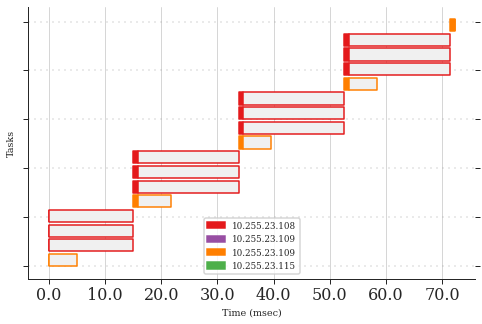

In [334]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import os
import json
import itertools
import matplotlib
import matplotlib.ticker as ticker


def build_graph(gfile):
    with open(gfile, 'r') as fd:
        raw = fd.read().split('\n')
        g = gt.Graph(directed=True)
        vid_to_vx = {}
        name_to_vid = {}

        g.vertex_properties['name'] = g.new_vertex_property("string")
        g.vertex_properties['worker'] = g.new_vertex_property("string")

        for ln in raw:
            if ln.startswith('v'):
                _, vid, name = ln.split(',', 2)
                v = g.add_vertex()
                vid_to_vx[vid] = v
                name_to_vid[name] = v
                g.vp.name[v] = name
      
        for ln in raw:
            if ln.startswith('e'):
                _, vsrc, vdst, _ = ln.split(',', 3)
                g.add_edge(vid_to_vx[vsrc], vid_to_vx[vdst])
    return g, name_to_vid



def format_xticks(x, pos=None):
    return x
    #return str(int(x*1000))
    

sns.set_style("ticks")
sns.set_context("paper", font_scale=1)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')
#ax.axes.get_yaxis().set_visible(False)

# Setting graph attribute
ax.grid(True)

worker_color = {'10.255.23.108': '#e41a1c',
                '10.255.23.109': '#984ea3',
                '10.255.23.110': '#ff7f00',
                '10.255.23.115': '#4daf4a'}

yticks = []
workers_load={}
logfile = '/local0/serverless/serverless-sim/results/all2all4x41GB1B_58e5586a.chain_color_rr.log'
gfile = '/opt/dask-distributed/benchmark/stats/all2all4x41GB1B_58e5586a.g'
g, name_to_vid = build_graph(gfile)
with open(logfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    base = 0; size = 5; margin = 1
    for ts in data['tasks']:
        #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
        if ts['worker'] not in workers_load:
            workers_load[ts['worker']] = []
        #ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
        #               facecolors =(worker_color[ts['worker']]))
        ax.broken_barh([(ts['start_ts'], ts['fetch_time'])], (base, size), 
                       edgecolors =worker_color[ts['worker']], facecolors =(worker_color[ts['worker']]))
        ax.broken_barh([(ts['start_ts'] + ts['fetch_time'], ts['computation_time'])], (base, size), 
                       edgecolors =worker_color[ts['worker']], facecolors='#f0f0f0')
        yticks.append(str(name_to_vid[ts['name']]))
        #for vin in name_to_vid[ts['name']].in_neighbors():
        #    print(vin)
        base += (size + margin)
ax.set_yticklabels(yticks)
ax.legend(['10.255.23.108', '10.255.23.109', '10.255.23.109', '10.255.23.115'], loc=8)
ax.get_legend().legendHandles[0].set_color(worker_color['10.255.23.108'])
ax.get_legend().legendHandles[1].set_color(worker_color['10.255.23.109'])
ax.get_legend().legendHandles[2].set_color(worker_color['10.255.23.110'])
ax.get_legend().legendHandles[3].set_color(worker_color['10.255.23.115'])
plt.show()


fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')
#ax.axes.get_yaxis().set_visible(False)

# Setting graph attribute
ax.grid(True)


yticks = []
workers_load={}
logfile = '/local0/serverless/serverless-sim/results/all2all4x41GB1B_58e5586a.optimal.log'
gfile = '/opt/dask-distributed/benchmark/stats/all2all4x41GB1B_58e5586a.g'
g, name_to_vid = build_graph(gfile)
with open(logfile, 'r') as fd:
    data2 = ast.literal_eval(fd.read())
    base = 0; size = 5; margin = 1
    for ts in data2['tasks']:
        #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
        if ts['worker'] not in workers_load:
            workers_load[ts['worker']] = []
        #ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
        #               facecolors =(worker_color[ts['worker']]))
        ax.broken_barh([(ts['start_ts'], ts['fetch_time'])], (base, size), 
                       edgecolors =worker_color[ts['worker']], facecolors =(worker_color[ts['worker']]))
        ax.broken_barh([(ts['start_ts'] + ts['fetch_time'], ts['computation_time'])], (base, size), 
               edgecolors =worker_color[ts['worker']], facecolors='#f0f0f0')
        yticks.append(str(name_to_vid[ts['name']]))
        #for vin in name_to_vid[ts['name']].in_neighbors():
        #    print(vin)
        base += (size + margin)
ax.set_yticklabels(yticks)
ax.legend(['10.255.23.108', '10.255.23.109', '10.255.23.109', '10.255.23.115'], loc=8)
ax.get_legend().legendHandles[0].set_color(worker_color['10.255.23.108'])
ax.get_legend().legendHandles[1].set_color(worker_color['10.255.23.109'])
ax.get_legend().legendHandles[2].set_color(worker_color['10.255.23.110'])
ax.get_legend().legendHandles[3].set_color(worker_color['10.255.23.115'])
plt.show()


fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('Tasks')
#ax.axes.get_yaxis().set_visible(False)

# Setting graph attribute
ax.grid(True)

yticks = []
workers_load={}
logfile = '/local0/serverless/serverless-sim/results/all2all4x41GB1B_58e5586a.vanilla.log'
gfile = '/opt/dask-distributed/benchmark/stats/all2all4x41GB1B_58e5586a.g'
g, name_to_vid = build_graph(gfile)
with open(logfile, 'r') as fd:
    data3 = ast.literal_eval(fd.read())
    base = 0; size = 5; margin = 1
    for ts in data3['tasks']:
        print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
        if ts['worker'] not in workers_load:
            workers_load[ts['worker']] = []
        ax.broken_barh([(ts['start_ts'], ts['fetch_time'])], (base, size), 
               edgecolors =worker_color[ts['worker']], facecolors =(worker_color[ts['worker']]))
        ax.broken_barh([(ts['start_ts'] + ts['fetch_time'], ts['computation_time'])], (base, size), 
               edgecolors =worker_color[ts['worker']], facecolors='#f0f0f0')
        #yticks.append(str(name_to_vid[ts['name']]))
        #for vin in name_to_vid[ts['name']].in_neighbors():
        #    print(vin)
        base += (size + margin)
ax.set_yticklabels(yticks)
ax.legend(['10.255.23.108', '10.255.23.109', '10.255.23.109', '10.255.23.115'], loc=8)
ax.get_legend().legendHandles[0].set_color(worker_color['10.255.23.108'])
ax.get_legend().legendHandles[1].set_color(worker_color['10.255.23.109'])
ax.get_legend().legendHandles[2].set_color(worker_color['10.255.23.110'])
ax.get_legend().legendHandles[3].set_color(worker_color['10.255.23.115'])
plt.show()

In [295]:
dt = pd.DataFrame(data['tasks'])
dt

,name,id,transfer,cpu_time,computation_time,remote_read,local_read,fetch_time,start_ts,worker,deserialization_time,serialization_time,end_ts,task_endtoend_delay,write,wait_for_serialization
0,execute_point_no_scratch-c45200fd-6261-4345-bc...,0,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.108,0,0.0,5.000000,5.000000,1073741824,0
1,execute_point_no_scratch-80b27d8c-307c-48fc-8a...,11,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.109,0,0.0,5.000000,5.000000,1073741824,0
2,execute_point_no_scratch-39f5a039-ada4-45d3-ad...,12,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.110,0,0.0,5.000000,5.000000,1073741824,0
3,execute_point_no_scratch-44cf700e-2280-48a4-9d...,15,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.115,0,0.0,5.000000,5.000000,1073741824,0
4,execute_point_no_scratch-2fa5355a-f8fe-4d78-a3...,13,7.200008,6,6.0,3221225472,1073741824,3.200003,5.000000,10.255.23.110,0,0.0,14.200003,9.200003,1073741824,0
5,execute_point_no_scratch-ec188590-d49d-43cd-94...,7,7.200008,6,6.0,3221225472,1073741824,3.200003,5.000000,10.255.23.109,0,0.0,14.200003,9.200003,1073741824,0
6,execute_point_no_scratch-9a1fdfc4-9a42-4ff0-a4...,14,7.200008,6,6.0,3221225472,1073741824,3.200003,5.000000,10.255.23.115,0,0.0,14.200003,9.200003,1073741824,0
7,execute_point_no_scratch-26026e7b-94a7-410c-b9...,5,9.600009,6,6.0,3221225472,1073741824,4.000003,5.000000,10.255.23.108,0,0.0,15.000003,10.000003,1073741824,0
8,execute_point_no_scratch-45dcc8da-7d8f-4469-bf...,16,7.200008,5,5.0,3221225472,1073741824,3.200003,15.000003,10.255.23.115,0,0.0,23.200006,8.200003,1073741824,0
9,execute_point_no_scratch-04993c02-9a45-48df-99...,2,7.200008,6,6.0,3221225472,1073741824,3.200003,15.000003,10.255.23.108,0,0.0,24.200006,9.200003,1073741824,0


In [285]:
dt2 = pd.DataFrame(data2['tasks'])
dt2

,name,id,transfer,cpu_time,computation_time,remote_read,local_read,fetch_time,start_ts,worker,deserialization_time,serialization_time,end_ts,task_endtoend_delay,write,wait_for_serialization
0,execute_point_no_scratch-c45200fd-6261-4345-bc...,0,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.108,0,0.0,5.000000,5.000000,1073741824,0
1,execute_point_no_scratch-80b27d8c-307c-48fc-8a...,11,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.115,0,0.0,5.000000,5.000000,1073741824,0
2,execute_point_no_scratch-39f5a039-ada4-45d3-ad...,12,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.110,0,0.0,5.000000,5.000000,1073741824,0
3,execute_point_no_scratch-44cf700e-2280-48a4-9d...,15,0.000000,5,5.0,0,0,0.000000,0.000000,10.255.23.109,0,0.0,5.000000,5.000000,1073741824,0
4,execute_point_no_scratch-26026e7b-94a7-410c-b9...,5,7.200008,6,6.0,3221225472,1073741824,3.200003,5.000000,10.255.23.115,0,0.0,14.200003,9.200003,1073741824,0
5,execute_point_no_scratch-2fa5355a-f8fe-4d78-a3...,13,7.200008,6,6.0,3221225472,1073741824,3.200003,5.000000,10.255.23.110,0,0.0,14.200003,9.200003,1073741824,0
6,execute_point_no_scratch-9a1fdfc4-9a42-4ff0-a4...,14,7.200008,6,6.0,3221225472,1073741824,3.200003,5.000000,10.255.23.109,0,0.0,14.200003,9.200003,1073741824,0
7,execute_point_no_scratch-ec188590-d49d-43cd-94...,7,12.000010,6,6.0,3221225472,1073741824,4.800004,5.000000,10.255.23.108,0,0.0,15.800004,10.800004,1073741824,0
8,execute_point_no_scratch-45dcc8da-7d8f-4469-bf...,16,7.200008,5,5.0,3221225472,1073741824,3.200003,15.800004,10.255.23.115,0,0.0,24.000007,8.200003,1073741824,0
9,execute_point_no_scratch-04993c02-9a45-48df-99...,2,7.200008,6,6.0,3221225472,1073741824,3.200003,15.800004,10.255.23.110,0,0.0,25.000007,9.200003,1073741824,0
